# 32 · Visual odometry monocular basada en características

## Definición de odometría visual

La odometría visual estima el movimiento de una cámara (traslación y rotación) a partir de secuencias de imágenes. En el caso monocular, se dispone de una sola cámara y la trayectoria se recupera hasta un factor de escala global. Sea $\{I_t\}$ una secuencia de imágenes adquiridas por una cámara con matriz intrínseca $K$. Para cada par de cuadros consecutivos $(I_t, I_{t+1})$ se buscan correspondencias entre puntos de imagen y se estima la pose relativa mediante geometría epipolar.

## Matriz esencial y recuperación de la pose relativa

Sea $\mathbf{x}_t$ y $\mathbf{x}_{t+1}$ la proyección normalizada de un mismo punto 3D en las imágenes $t$ y $t+1$ respectivamente. La matriz esencial $E$ satisface

$\mathbf{x}_{t+1}^\top E \, \mathbf{x}_t = 0$

para todas las correspondencias válidas. A partir de un conjunto de pares de puntos se estima $E$ mediante un método robusto (por ejemplo RANSAC). Dada la matriz esencial y la matriz intrínseca $K$, es posible recuperar la rotación relativa $R$ y la traslación relativa $\mathbf{t}$ (hasta un factor de escala) entre las posiciones de la cámara en $t$ y $t+1$.

## Integración incremental de la trayectoria

Sea $(R_k, \mathbf{t}_k)$ la pose relativa entre los cuadros $k-1$ y $k$. La pose acumulada de la cámara en un sistema de referencia inicial se puede obtener de manera incremental como

$R_{\text{cum},k} = R_{\text{cum},k-1} \, R_k$

$\mathbf{T}_{\text{cum},k} = \mathbf{T}_{\text{cum},k-1} + R_{\text{cum},k-1} \, \alpha_k \, \mathbf{t}_k$

donde $\alpha_k$ es un factor de escala (desconocido en odometría monocular pura). En una aproximación simplificada se puede fijar $\alpha_k = 1$ o normalizar $\mathbf{t}_k$ para visualizar la forma de la trayectoria relativa.

Imports, ruta del video y parámetros intrínsecos de la cámara.

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

VIDEO_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\sequence2.mp4"

K = None

Lectura del primer frame y definición de la matriz intrínseca aproximada.

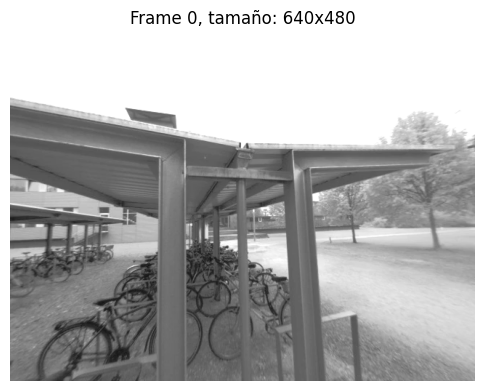

Matriz intrínseca K estimada:
[[576.   0. 320.]
 [  0. 576. 240.]
 [  0.   0.   1.]]


In [22]:
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame0 = cap.read()
if not ret:
    cap.release()
    raise RuntimeError("No se pudo leer el primer frame del video.")

h0, w0 = frame0.shape[:2]
fx = 0.9 * w0
fy = 0.9 * w0
cx = w0 / 2.0
cy = h0 / 2.0
K = np.array([[fx, 0,  cx],
              [0,  fy, cy],
              [0,  0,  1 ]], dtype=np.float64)

rgb0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,5))
plt.imshow(rgb0)
plt.title(f"Frame 0, tamaño: {w0}x{h0}")
plt.axis("off")
plt.show()

print("Matriz intrínseca K estimada:")
print(K)

Definición del detector y descriptor de características (ORB).

In [23]:
orb = cv2.ORB_create(nfeatures=1000, scaleFactor=1.2, nlevels=8,
                     edgeThreshold=31, firstLevel=0, WTA_K=2,
                     scoreType=cv2.ORB_HARRIS_SCORE, patchSize=31, fastThreshold=20)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

Cálculo incremental de la trayectoria mediante correspondencias entre cuadros consecutivos, matriz esencial y recuperación de la pose.

In [24]:
cap.release()
cap = cv2.VideoCapture(VIDEO_PATH)

ret, prev_frame = cap.read()
if not ret:
    cap.release()
    raise RuntimeError("No se pudo reiniciar la lectura del video.")

prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
kp_prev, des_prev = orb.detectAndCompute(prev_gray, None)

R_cum = np.eye(3, dtype=np.float64)
T_cum = np.zeros((3,1), dtype=np.float64)

traj_points = [T_cum.copy()]
frame_ids = [0]

max_frames = 300
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    if frame_idx > max_frames:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    kp, des = orb.detectAndCompute(gray, None)

    if des_prev is None or des is None or len(kp_prev) < 8 or len(kp) < 8:
        prev_gray = gray
        kp_prev, des_prev = kp, des
        continue

    matches = bf.match(des_prev, des)
    if len(matches) < 8:
        prev_gray = gray
        kp_prev, des_prev = kp, des
        continue

    matches = sorted(matches, key=lambda m: m.distance)
    good_matches = matches[:200]

    pts_prev = np.float32([kp_prev[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    pts_curr = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    E, mask = cv2.findEssentialMat(pts_curr, pts_prev, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    if E is None:
        prev_gray = gray
        kp_prev, des_prev = kp, des
        continue

    inliers, R, t, mask_pose = cv2.recoverPose(E, pts_curr, pts_prev, K)
    if inliers < 10:
        prev_gray = gray
        kp_prev, des_prev = kp, des
        continue

    t_norm = t / max(np.linalg.norm(t), 1e-6)

    T_cum = T_cum + R_cum @ t_norm
    R_cum = R @ R_cum

    traj_points.append(T_cum.copy())
    frame_ids.append(frame_idx)

    prev_gray = gray
    kp_prev, des_prev = kp, des

cap.release()

traj = np.hstack(traj_points)
xs = traj[0,:]
zs = traj[2,:]

Visualización de la trayectoria relativa estimada en el plano X–Z de la cámara.

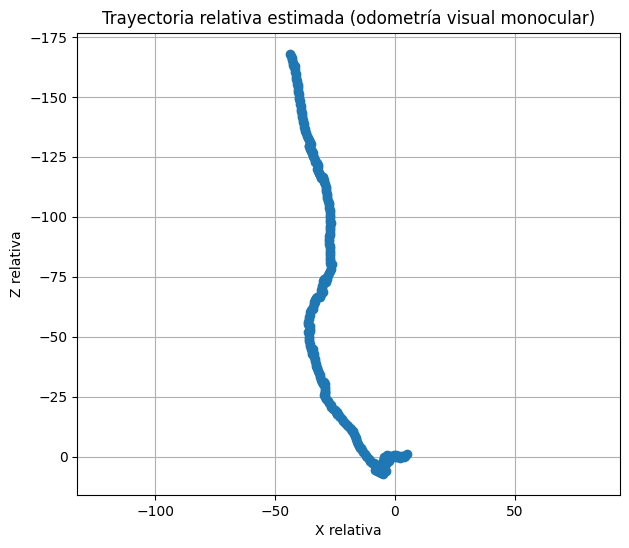

Frames usados: 300


In [25]:
plt.figure(figsize=(7,6))
plt.plot(xs, zs, marker='o', linestyle='-', linewidth=2)
plt.xlabel("X relativa")
plt.ylabel("Z relativa")
plt.title("Trayectoria relativa estimada (odometría visual monocular)")
plt.grid(True)
plt.axis('equal')
plt.gca().invert_yaxis()
plt.show()

print(f"Frames usados: {len(frame_ids)}")